# 1. Introduction

Présentation de l’objectif du notebook :  
- Réaliser un clustering K-Means sur les données prétraitées  
- Identifier les groupes de patients selon leurs profils cliniques  
- Visualiser et analyser ces clusters  
- Définir une catégorie de risque basée sur les clusters





# 2. Chargement des données

- Import des données standardisées issues du notebook de prétraitement 


In [331]:
import pandas as pd
df_cluster= pd.read_csv('../data/df_cluster.csv')
df_cluster=pd.DataFrame(df_cluster)
df_cluster_scaled = pd.read_csv('../data/df_cluster_scaled.csv')
df_cluster_scaled=pd.DataFrame(df_cluster_scaled)

 
- Vérification rapide de la forme et des colonnes



In [332]:
print("\n \n📊 Aperçu des données pour le clustering :\n")
print("Données filtrées (df_cluster) :")
print(df_cluster.head())
print("\nDonnées standardisées (df_cluster_scaled) :")
df_cluster_scaled


 
📊 Aperçu des données pour le clustering :

Données filtrées (df_cluster) :
   Glucose   BMI  DiabetesPedigreeFunction   Age
0    148.0  33.6                     0.627  50.0
1     85.0  26.6                     0.351  31.0
2    183.0  23.3                     0.672  32.0
3     89.0  28.1                     0.167  21.0
4    137.0  43.1                     1.500  33.0

Données standardisées (df_cluster_scaled) :


,Glucose,BMI,DiabetesPedigreeFunction,Age
0,0.849933,0.179195,0.516226,1.431701
1,-1.200262,-0.869912,-0.384190,-0.198974
2,1.988930,-1.364490,0.663033,-0.113149
3,-1.070091,-0.645103,-0.984467,-1.057224
4,0.491962,1.602982,3.364280,-0.027324
...,...,...,...,...
719,-0.679578,0.074284,-0.971418,2.547426
720,0.003821,0.658786,-0.420076,-0.542274
721,-0.028722,-0.929861,-0.730002,-0.284799
722,0.133992,-0.345358,-0.390715,1.174226




# 3. Recherche du nombre optimal de clusters

- Explication de la méthode du coude pour déterminer k  
- Calcul et visualisation de la courbe d’inertie en fonction de k


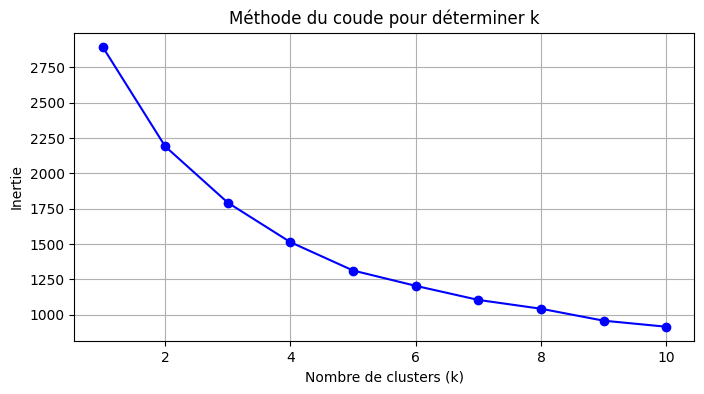

In [333]:
from sklearn.cluster import KMeans
import  matplotlib.pyplot as plt
# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Affichage de la courbe du coude
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.grid(True)
plt.show()




# 4. Entraînement du modèle K-Means

- Choix du nombre de clusters optimal  


In [334]:
k_optimal = 2


- Entraînement du modèle avec ce k  


In [335]:
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels= kmeans.fit_predict(df_cluster_scaled)


- Ajout de la colonne « Cluster » au DataFrame



In [336]:
df_cluster['cluster'] = cluster_labels


# 5. Visualisation des clusters

- Visualisation des clusters dans l’espace des données initiales (ex. pairplot ou scatter plot)  


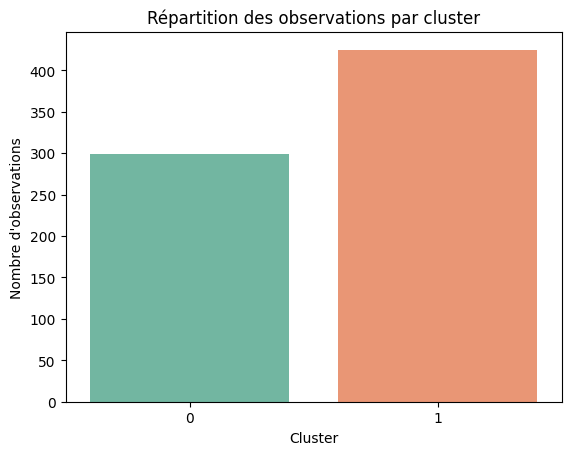

In [337]:
import seaborn as sns
sns.countplot(x='cluster', hue='cluster', data=df_cluster, palette='Set2', legend=False)
plt.title('Répartition des observations par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'observations')
plt.show()



- Réduction dimensionnelle avec ACP (PCA) pour passer à 2 dimensions  


In [338]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_cluster_scaled)
df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

- Réentraîner K-Means sur les composantes principales 


In [339]:
kmeans_pca = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels_pca=kmeans_pca.fit_predict(df_pca)
df_pca['cluster'] = cluster_labels_pca



- Visualiser les clusters dans cet espace réduit

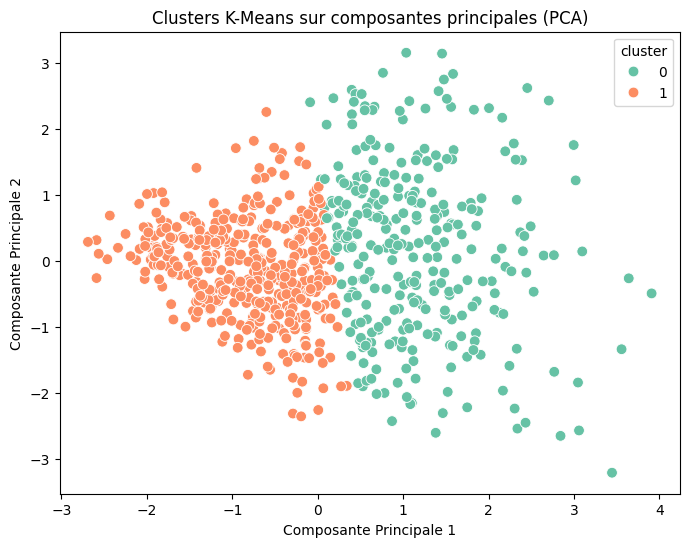

In [340]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)
plt.title('Clusters K-Means sur composantes principales (PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='cluster')
plt.show()

---



# 6. Analyse des clusters

- Calcul des moyennes des variables clés par cluster  


In [341]:
moy_by_cluster = df_cluster.groupby('cluster').mean()
print("\n \n📊 Moyennes des variables par cluster :\n", moy_by_cluster)


 
📊 Moyennes des variables par cluster :
             Glucose        BMI  DiabetesPedigreeFunction        Age
cluster                                                            
0        146.264214  35.698328                  0.569920  40.705686
1        104.729412  30.086941                  0.397598  28.121176


- Identification des clusters à risque élevé selon seuils cliniques  


In [342]:
seuils = {
    'Glucose': 126,
    'BMI': 30,
    'DiabetesPedigreeFunction': 0.5
}
def classify_risk(row):
    if row['Glucose'] >= seuils['Glucose'] and row['BMI'] >= seuils['BMI'] and row['DiabetesPedigreeFunction'] >= seuils['DiabetesPedigreeFunction']:
        return 'Haut risque'
    else:
        return 'Bas risque'
moy_by_cluster['Risque'] = moy_by_cluster.apply(classify_risk, axis=1)
print("\n \n📊 Moyennes des variables par cluster avec classification du risque :\n", moy_by_cluster)


 
📊 Moyennes des variables par cluster avec classification du risque :
             Glucose        BMI  DiabetesPedigreeFunction        Age  \
cluster                                                               
0        146.264214  35.698328                  0.569920  40.705686   
1        104.729412  30.086941                  0.397598  28.121176   

              Risque  
cluster               
0        Haut risque  
1         Bas risque  


- Comptage du nombre d’observations par cluster  


In [343]:
count_by_risk = moy_by_cluster['Risque'].value_counts()
print("\n \n📊 Nombre d'observations par risque :\n", count_by_risk)


 
📊 Nombre d'observations par risque :
 Risque
Haut risque    1
Bas risque     1
Name: count, dtype: int64


- Création d’une colonne « risk_category » selon la définition des risques


In [344]:
# Définir la règle simple de risque selon le numéro de cluster
def definir_risque(cluster_num):
    if cluster_num == 0:
        return 'risque élevé'
    else:
        return 'risque faible'

df_cluster['risk_category'] = df_cluster['cluster'].apply(definir_risque)

print(df_cluster[['cluster', 'risk_category']].head())



   cluster  risk_category
0        0   risque élevé
1        1  risque faible
2        0   risque élevé
3        1  risque faible
4        0   risque élevé


C:\Users\user\AppData\Local\Temp\ipykernel_20324\177180178.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_category', data=df_cluster, palette='Set1')


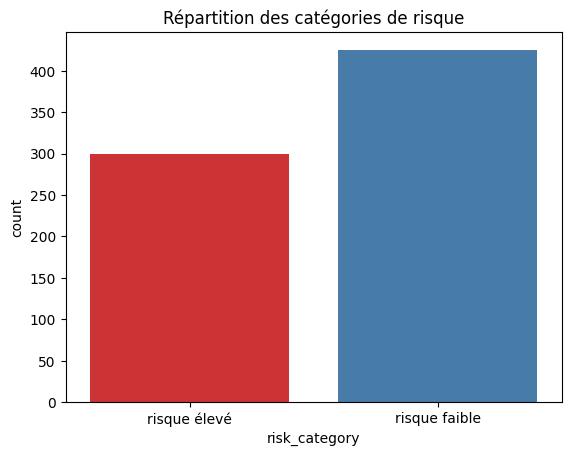

In [345]:
sns.countplot(x='risk_category', data=df_cluster, palette='Set1')
plt.title("Répartition des catégories de risque")
plt.show()



---



# 7. Conclusion

- Synthèse des résultats obtenus  


In [346]:
# Exemple simple de synthèse des résultats
print("Résumé des clusters et catégories de risque :")
print(df_cluster.groupby(['cluster', 'risk_category']).size())

Résumé des clusters et catégories de risque :
cluster  risk_category
0        risque élevé     299
1        risque faible    425
dtype: int64



- Perspectives pour la suite : classification supervisée, intégration dans un pipeline complet


In [347]:

# Perspectives possibles
print("\nPerspectives :")
print("- Mettre en place une classification supervisée pour prédire le risque sur de nouvelles données.")
print("- Intégrer ce clustering et classification dans un pipeline de traitement complet automatisé.")



Perspectives :
- Mettre en place une classification supervisée pour prédire le risque sur de nouvelles données.
- Intégrer ce clustering et classification dans un pipeline de traitement complet automatisé.



---

# 8. Sauvegarde

- Sauvegarde du DataFrame enrichi (avec cluster et risk_category) pour utilisation ultérieure


In [348]:
df_cluster.to_csv('../data/df_cluster_enrichi.csv', index=False)

print("DataFrame enrichi sauvegardé dans 'df_cluster_enrichi.csv'.")
 

DataFrame enrichi sauvegardé dans 'df_cluster_enrichi.csv'.
